In [272]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import special
from numpy.random import default_rng
from scipy.optimize import fsolve
rng = default_rng()
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.style.use(['fivethirtyeight'])
plt.rcParams['font.family'] = 'monospace'


In [25]:
def gaussian_mix(x, mu, s):
    """ Function evaluates a normalized sum of N Gaussian functions
    
    Parameters 
    ----------
    x
        Input vector of points
    mu
        Input vector of means 
    s
        Scalar, standard deviation 
    
    Returns 
    ----------
    The estimation of probability density function at each point
    """
    N = len(mu)
    G = 0
    for i in range(N):
        G = G + np.exp(-(x-mu[i])**2/(2*s**2))/np.sqrt(2*np.pi*s**2)
    
    return G/N


Text(0.5, 1.0, 'Playing around Gaussian Kernels')

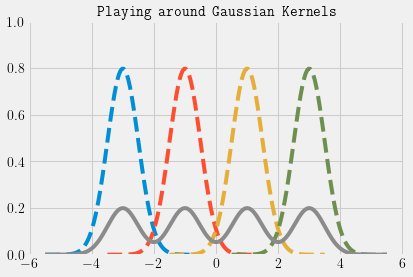

In [273]:
mu = [-3,-1,1,3] #Vector of means for individual Gaussian distributions
s = 0.5 #Standard deviation of all Gaussian distributions
N = len(mu)
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = plt.axes()
ax.set_ylim(bottom=0)
for i in range(N):
    x = np.r_[mu[i]-5*s:mu[i]+5*s:100j]
    y = np.exp(-(x-mu[i])**2/(2*s**2))/np.sqrt(2*np.pi*s**2)

    ax.plot(x,y, '--')

x = np.r_[min(mu)-5*s:max(mu)+5*s:500j]
y = gaussian_mix(x,mu,s)
ax.plot(x,y)
ax.set_title('Playing around with Gaussian Kernels', fontsize = 15)



In [285]:
#Downloading data and taking log of returns
data = pd.read_csv('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/c1/body_tail_calibration/cryptocurrency_prices.txt', header = None).iloc[0]
data = data.str.split(pat = '\t').tolist()
data = [item for sublist in data for item in sublist]
r = np.log(list(map(lambda x, y: float(x) / float(y), data[1:], data[0:-2])))


In [75]:
#Separating the data into training /validation /testing sets (one third of the data each)
pt, pv = 0.33, 0.33
train_set = r[:round(pt*len(r))]
n_t = len(train_set)
val_set= r[round(pt*len(r)):round((pt+pv)*len(r))]
test_set = r[round((pt+pv)*len(r)):]

In [80]:
#Maximum-likelihood analysis
h = np.logspace(-3,-1,100)
L = []

for i in range(len(h)):
    p = gaussian_mix(val_set, train_set, h[i])
    L.append(sum(np.log(p))) #log because it's a log-likelihood

In [88]:
#Finding the optimal bandwidth value 
h_opt = h[L.index(max(L))]
print('Optimat kernel width: {:4.3f}'.format(h_opt))

Optimat kernel width: 0.007


Text(0, 0.5, '$q_2$')

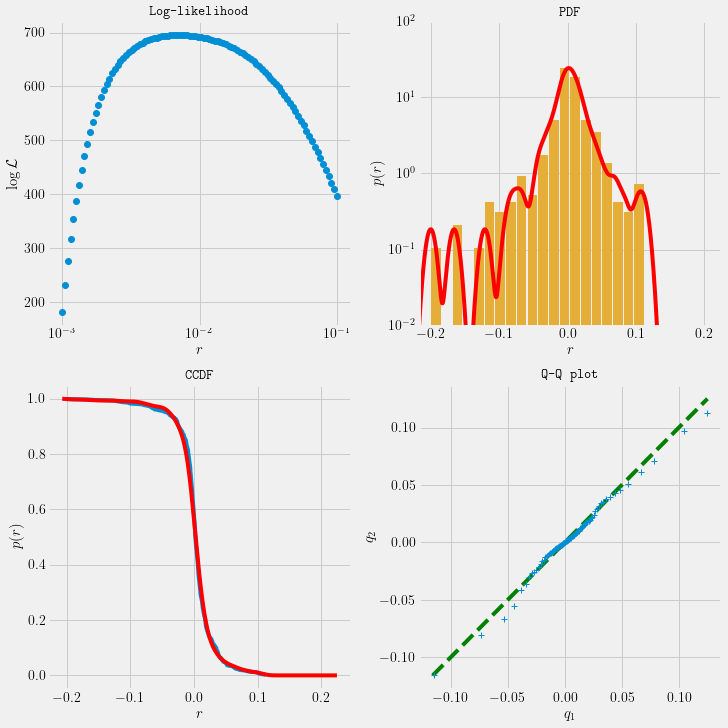

In [274]:
#Plotting of optimal Gaussian kernel distributon's PDF vs histogram of training + validation set
x = np.r_[min(r)*1.05:max(r)*1.05:1000j]
y = gaussian_mix(x, train_set, h_opt) #Values of kernel density for optimal bandwidth
NB = 20

#Plotting of optimal Gaussian kernel distribution PDF vs rank-frequency plot of training + validation set
aux = sorted(np.r_[train_set,val_set])
y1 = np.linspace(1,len(aux), len(aux))
y1 = 1 - y1/(len(aux)+1)

#Plotting of optimal Gaussian kernel distribution CCDF vs rank-frequency plot of training + validation set
x1 = np.r_[min(r):max(r):500j]
C = [] #Expty vector to store values of kernel's CCDF
for i in range(len(x1)):
    tmp = sum(1-special.erf((x1[i]-train_set)/np.sqrt(2*(h_opt**2))))/(2*n_t)
    C.append(tmp)

#Q-Q plot og Gaussian kernel vs empirical distribution
f = lambda x,*args: sum(1+special.erf((x-train_set)/np.sqrt(2*(h_opt**2))))/(2*n_t) - args[0]
n_rand = 5000 #number of random numbers to be generated
kernel_rand = []
for i in range(n_rand):
    u = rng.uniform(size = 1)
    args = [u]
    y2 = fsolve(f, x0 = 0, args = (args[0]))
    kernel_rand.append(y2)

pvec = np.r_[1:100:100j]
qn_a = np.percentile(np.r_[train_set,val_set], pvec)
qn_b = np.percentile(kernel_rand, pvec)


#Plotting 
fig1, ax1 = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0,0].semilogx(h,L, 'o')
ax1[0,0].set_title('Log-likelihood', fontsize = 14)
#plt.rcParams.update({
   # "text.usetex": True })
ax1[0,0].set_xlabel(r'\textbf{$r$}', fontsize = 15)
ax1[0,0].set_ylabel(r'\textbf{$\log\mathcal{L}$', fontsize = 15)

ax1[0,1].semilogy(x,y, 'r')
ax1[0,1].set_xlim([min(x), max(r)])
ax1[0,1].set_ylim([1e-2, 100])
ax1[0,1].hist(np.r_[train_set,val_set], NB, density = True, rwidth = 0.90, log=True, align='mid', color = '#e5ae38')
ax1[0,1].set_title('PDF', fontsize = 14)
ax1[0,1].set_xlabel(r'\textbf{$r$}', fontsize = 15)
ax1[0,1].set_ylabel(r'\textbf{$p(r)$}', fontsize = 15)

ax1[1,0].plot(aux,y1)
ax1[1,0].plot(x1, C, 'r')
ax1[1,0].set_title('CCDF', fontsize = 14)
ax1[1,0].set_xlabel(r'\textbf{$r$}', fontsize = 15)
ax1[1,0].set_ylabel(r'\textbf{$p(r)$}', fontsize = 15)

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
ax1[1,1].plot(x,x, color="g", ls="--")
ax1[1,1].plot(qn_b,qn_a, ls="", marker="+")
ax1[1,1].set_title('Q-Q plot', fontsize = 14)
ax1[1,1].set_xlabel(r'$q_1$', fontsize = 15)
ax1[1,1].set_ylabel(r'$q_2$', fontsize = 15)

